In [8]:
%pylab inline
import numpy as np
import scipy as sp
import pylab as pb
import os
import sys
sys.path.append(os.getenv("HOME") + '/Desktop/DPhil_GitHub/Libraries')
import GPy
print(os.path)

Populating the interactive namespace from numpy and matplotlib
<module 'posixpath' from '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/posixpath.pyc'>


In [297]:
'''
One dimensional metrics & distances between gaussians
'''

def KL_Div(m1,s1,m2,s2):
    p1 = np.log(s2/s1) - 1
    p2 = (s1/s2)
    p3 = (m1 - m2)**2/s2
    return 0.5*(p1+p2+p3)

def symetical_Div(m1,s1,m2,s2):
    return KL_Div(m1,s1,m2,s2) + KL_Div(m2,s2,m1,s1)

def bhatt_distance(m1,s1,m2,s2):
    p1 = np.log(((s1/s2) + (s2/s1) + 2)/4)
    p2 = (m1 - m2)**2/(s1 + s2)
    return (p1 + p2)/4

def W_0(m1,s1,m2,s2):
    return (m1 - m2)**2

def W_2(m1,s1,m2,s2):
    p1 = (m1 - m2)**2
    p2 = s1 + s2 - 2*np.sqrt(s1*s2)
    return p1 + p2

def performance(m1,s1,m2,s2):
    ind = np.where(s1>1e-3)
    m1 = m1[ind]
    s1 = s1[ind]
    m2 = m2[ind]
    s2 = s2[ind]
    kl1 = KL_Div(m1,s1,m2,s2)
    kl2 =  KL_Div(m2,s2,m1,s1)
    sd = symetical_Div(m1,s1,m2,s2)
    bd = bhatt_distance(m1,s1,m2,s2)
    w0 = W_0(m1,s1,m2,s2)
    w2 = W_2(m1,s1,m2,s2)
        
    np.set_printoptions(precision=3)
    
    print 'KL(P||Q) \t', '%.2f' % kl1.mean(), '\t', '%.2f' %np.median(kl1),'\t', '%.2f' %kl1.max(), '\t', '%.2f' %kl1.min()
    #print 'KL(P||Q) \t', '%.2f' % kl2.mean(), '\t', '%.2f' %np.median(kl2),'\t', '%.2f' %kl2.max(), '\t', '%.2f' %kl2.min()
    #print 'J(P,Q) \t\t', '%.2f' %sd.mean(), '\t', '%.2f' %np.median(sd),'\t', '%.2f' %sd.max(), '\t', '%.2f' %sd.min()
    print 'B(P,Q) \t\t', '%.2f' %bd.mean(), '\t', '%.2f' %np.median(bd),'\t', '%.2f' %bd.max(), '\t', '%.2f' %bd.min()
    print 'W_0(P,Q) \t','%.2f' % w0.mean(), '\t', '%.2f' %np.median(w0),'\t', '%.2f' %w0.max(), '\t', '%.2f' %w0.min()
    print 'W_2(P,Q) \t','%.2f' % w2.mean(), '\t', '%.2f' %np.median(w2),'\t', '%.2f' %w2.max(), '\t', '%.2f' %w2.min()
    
print '''
Prints the following performance metrics from samples:

KL Divergence (each way)
Symetrical Divergence
Bhattacharrya Distance
0^th Wasserstein Distance
2^nd Wasserstein Distance
'''


Prints the following performance metrics from samples:

KL Divergence (each way)
Symetrical Divergence
Bhattacharrya Distance
0^th Wasserstein Distance
2^nd Wasserstein Distance



In [10]:
'''
Test the performance metrics
'''

m1 = np.array([0,1,-2,3])
m2 = np.array([1,0,-2,4])

s1 = np.array([0.5,1,2,1])
s2 = np.array([0.8,2,1.5,1])

performance(m1,s1,m2,s2)

KL(P||Q) 	0.39 	0.42 	0.67 	0.02
B(P,Q) 		0.11 	0.12 	0.21 	0.01
W_0(P,Q) 	0.75 	1.00 	1.00 	0.00
W_2(P,Q) 	0.81 	1.02 	1.17 	0.04


In [248]:
def true_GP(x,y,z):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp = GPy.models.GPRegression(x,y,kern)

    # There is no noise on our observations
    gp['noise'] = 0
    
    out = gp.predict(z)
    
    M = out[0]
    V = out[1]
        
    return M, V

def poe_GP(X,Y,z):
    # split the data into two parts
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1]    
    poe_v =  (1/V2) + (1/V1)
    poe_v = 1/poe_v
    poe_m = poe_v * ((M1/V1) + (M2/V2))
    
    return poe_m, poe_v

def bcm_GP(X,Y,z):
    # split the data into two parts
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    bcm_v =  (1/V2) + (1/V1) - (1/gp1.K[0,0])
    bcm_v = 1/bcm_v
    bcm_m = bcm_v * ((M1/V1) + (M2/V2))
    
    return bcm_m, bcm_v

Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	0.80 	0.15 	6.44 	0.00
B(P,Q) 		0.35 	0.03 	3.12 	0.00
W_0(P,Q) 	0.11 	0.00 	0.94 	0.00
W_2(P,Q) 	0.21 	0.21 	0.95 	0.00

Performance of BCM...
KL(P||Q) 	0.69 	0.01 	6.47 	0.00
B(P,Q) 		0.31 	0.00 	3.14 	0.00
W_0(P,Q) 	0.11 	0.00 	1.31 	0.00
W_2(P,Q) 	0.13 	0.00 	1.43 	0.00



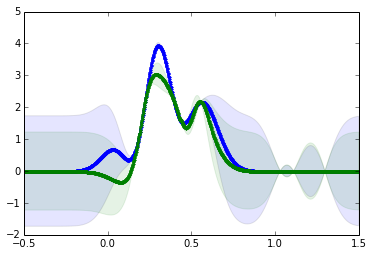

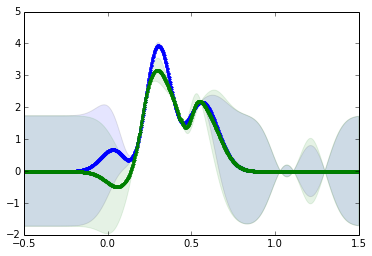

In [237]:
# We will examine a simple 1D example

def func(x):
    # Lets play around with a gausian mixture
    # and pretend we dont know what it is
    var_1 = 0.01
    var_2 = 0.03
    
    mean_1 = 0.3
    mean_2 = 0.6
    
    return ((1/np.sqrt(2*np.pi*var_1))*np.exp(-pow(x-mean_1,2)/var_1)) \
                + ((1/np.sqrt(2*np.pi*var_2))*np.exp(-pow(x-mean_2,2)/var_2))
    
x = np.random.randn(10)/3 + 0.5
z = np.linspace(-0.5,1.5,1000)
y = func(x)

gp_m, gp_v = true_GP(x,y,z)
poe_m, poe_v = poe_GP(x,y,z)
bcm_m, bcm_v = bcm_GP(x,y,z)

gp_v[gp_v < 0] = 1e-10
poe_v[poe_v < 0] = 1e-10
bcm_v[bcm_v < 0] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, poe_m, 'g.')
plt.fill_between(z, (poe_m + np.sqrt(poe_v)).reshape(-1,), (poe_m - np.sqrt(poe_v)).reshape(-1,), alpha=0.1, color='green')

plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, bcm_m, 'g.')
plt.fill_between(z, (bcm_m + np.sqrt(bcm_v)).reshape(-1,), (bcm_m - np.sqrt(bcm_v)).reshape(-1,), alpha=0.1, color='green')

# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	0.47 	0.15 	4.05 	0.00
B(P,Q) 		0.18 	0.03 	1.93 	0.00
W_0(P,Q) 	0.18 	0.00 	2.70 	0.00
W_2(P,Q) 	0.26 	0.10 	2.70 	0.00

Performance of BCM...
KL(P||Q) 	0.40 	0.01 	4.07 	-0.00
B(P,Q) 		0.17 	0.00 	1.94 	0.00
W_0(P,Q) 	0.15 	0.00 	2.05 	0.00
W_2(P,Q) 	0.17 	0.00 	2.14 	-0.00

Performance of ER...
KL(P||Q) 	0.40 	0.01 	4.07 	-0.00
B(P,Q) 		0.17 	0.00 	1.94 	0.00
W_0(P,Q) 	0.15 	0.00 	2.05 	0.00
W_2(P,Q) 	0.17 	0.00 	2.14 	-0.00



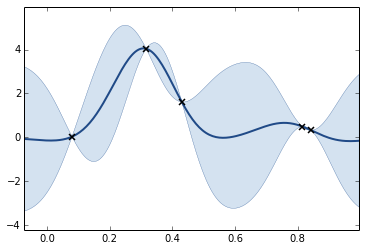

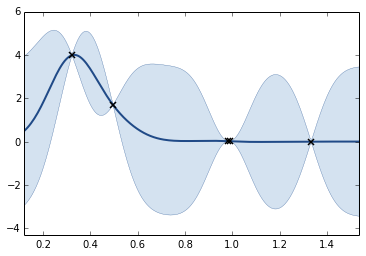

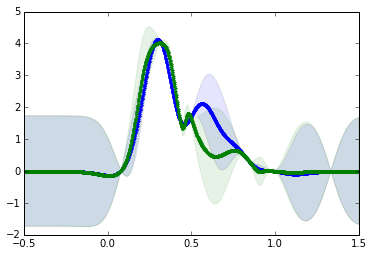

In [13]:
'''
Experimental Approach by finding correlations in expected error
'''

def er_GP(x,y,z):
    # split the data into two parts
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    gp1.plot()
    gp2.plot()
    plt.figure()
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
        
    er_v =  (1/V2) + (1/V1) - (1/gp1.K[0,0])
    er_v = 1/er_v
    er_m = er_v * ((M1/V1) + (M2/V2))
    
    '''ZV1 = V1 - gp1.K[0,0]
    ZV2 = V2 - gp1.K[0,0]
    
    plt.plot(z,ZV1**2)
    plt.plot(z,ZV2**2)
    plt.plot(z,ZV2*ZV1)
    plt.figure()
    p = np.sum((ZV1*ZV2))*2/(np.sum((ZV1**2)) + np.sum((ZV1**2)))
    #p = np.mean((ZV1 - np.mean(ZV1))*(ZV2 - np.mean(ZV2)))/(np.mean((ZV1 - np.mean(ZV1))**2)**0.5*(np.mean((ZV2 - np.mean(ZV2))**2)**0.5))
    print p
    
    for i in xrange(V1.shape[0]):
        e = np.eye(2)
        e[0,0] = V1[i]
        e[1,1] = V2[i]
        e[0,1] = np.sqrt(V1[i]*V2[i])*p
        e[1,0] = e[0,1]
        e_inv = np.linalg.inv(e)
        ee = np.sum(e_inv, 0)/np.sum(e_inv[:])
        er_m[i] = ee[0]*M1[i] + ee[1]*M2[i]
        #er_v[i] = np.sum(e) + (1/gp1.K[0,0])'''
            
    return er_m, er_v

er_m, er_v = er_GP(x,y,z)

gp_v[gp_v < 1e-10] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
#plt.plot(z, poe_m, 'r.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v, er_m, er_v)

print ''

Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	0.47 	0.15 	4.05 	0.00
B(P,Q) 		0.18 	0.03 	1.93 	0.00
W_0(P,Q) 	0.18 	0.00 	2.70 	0.00
W_2(P,Q) 	0.26 	0.10 	2.70 	0.00

Performance of BCM...
KL(P||Q) 	0.40 	0.01 	4.07 	-0.00
B(P,Q) 		0.17 	0.00 	1.94 	0.00
W_0(P,Q) 	0.15 	0.00 	2.05 	0.00
W_2(P,Q) 	0.17 	0.00 	2.14 	-0.00

Performance of ER...
KL(P||Q) 	935.69 	0.01 	840345.02 	-0.00
B(P,Q) 		426.54 	0.00 	388435.01 	0.00
W_0(P,Q) 	0.12 	0.00 	1.24 	0.00
W_2(P,Q) 	0.13 	0.00 	1.31 	-0.00



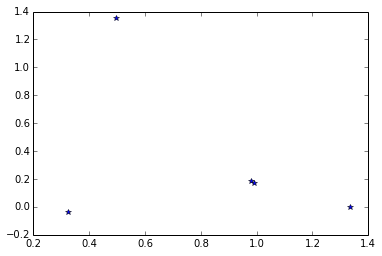

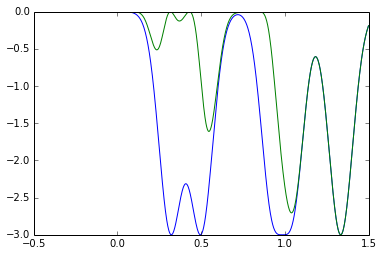

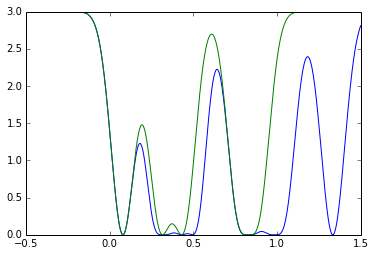

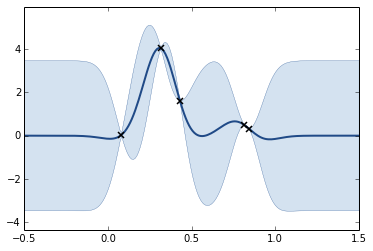

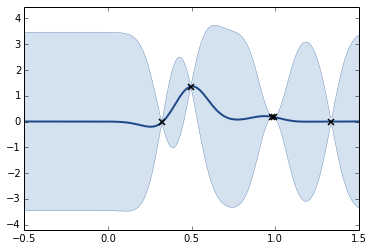

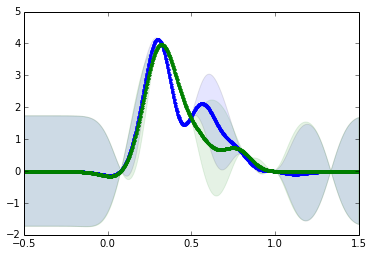

In [28]:
'''
Experimental Approach by finding correlations in expected error
'''

def er_GP(x,y,z):
    # split the data into two parts
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    

    # There is no noise on our observations
    gp1['noise'] = 0
    
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    
    yy2 = (y2-gp1.predict(x2)[0])
    
    plt.figure()
    plt.plot(x2, yy2,'*')
    
    gp2 = GPy.models.GPRegression(x2,yy2,kern)
    gp2['noise'] = 0
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    plt.figure()
    plt.plot(z,((V2-3)))
    plt.plot(z,((V1*(V2-3)/3)))
    plt.figure()
    plt.plot(z,(V1*(1 + ((V2-3)/3))))
    plt.plot(z,V1)
    plt.figure()
    
    gp1.plot(plot_limits=[-0.5,1.5])
    gp2.plot(plot_limits=[-0.5,1.5])
    plt.figure()
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
        
    er_v =  V1*(1 + (V2-3)/3)
    er_m = M1 + M2
        
    return er_m, er_v

er_m, er_v = er_GP(x,y,z)

#gp_v[gp_v < 1e-10] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v, er_m, er_v)

print ''

Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	0.47 	0.15 	4.05 	0.00
B(P,Q) 		0.18 	0.03 	1.93 	0.00
W_0(P,Q) 	0.18 	0.00 	2.70 	0.00
W_2(P,Q) 	0.26 	0.10 	2.70 	0.00

Performance of BCM...
KL(P||Q) 	0.40 	0.01 	4.07 	-0.00
B(P,Q) 		0.17 	0.00 	1.94 	0.00
W_0(P,Q) 	0.15 	0.00 	2.05 	0.00
W_2(P,Q) 	0.17 	0.00 	2.14 	-0.00

Performance of ER...
KL(P||Q) 	nan 	0.01 	nan 	nan
B(P,Q) 		nan 	0.00 	nan 	nan
W_0(P,Q) 	0.21 	0.00 	2.62 	0.00
W_2(P,Q) 	nan 	0.01 	nan 	nan



/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:71: RuntimeWarning: invalid value encountered in sqrt
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in log
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: invalid value encountered in log
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: invalid value encountered in sqrt


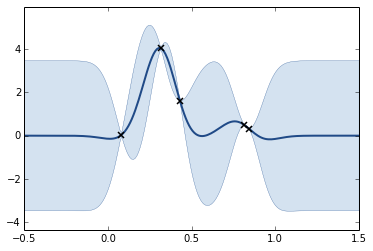

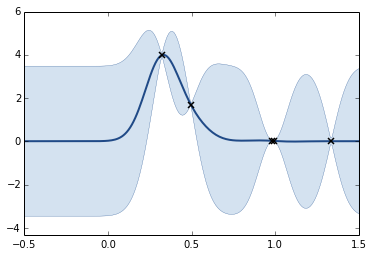

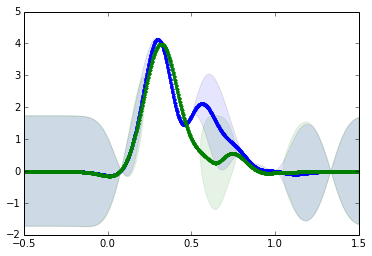

In [35]:
'''
Experimental Approach by finding correlations in expected error
'''

def er_GP(x,y,z):
    # split the data into two parts
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    

    # There is no noise on our observations
    gp1['noise'] = 0
    
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
        
    gp2 = GPy.models.GPRegression(x2,y2,kern)
    gp2['noise'] = 0
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    
    gp1.plot(plot_limits=[-0.5,1.5])
    gp2.plot(plot_limits=[-0.5,1.5])
    plt.figure()
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
        
    er_v =  V1 + V2 -3
    a = np.sqrt(-V1 + 3 + 1e-6)
    b = np.sqrt(-V2 + 3 + 1e-6)
    c = a+b
    er_m = (a*M1 + b*M2)/c
        
    return er_m, er_v

er_m, er_v = er_GP(x,y,z)

#gp_v[gp_v < 1e-10] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v, er_m, er_v)

print ''

[[ 0.497  0.199 -0.099 -0.398 -0.696 -0.994]
 [ 0.493  0.197 -0.099 -0.395 -0.69  -0.986]
 [ 0.489  0.196 -0.098 -0.392 -0.685 -0.979]
 ..., 
 [-0.614 -0.245  0.123  0.491  0.859  1.227]
 [-0.617 -0.247  0.123  0.494  0.864  1.235]
 [-0.621 -0.248  0.124  0.497  0.87   1.242]]
(300,) (300,) (300, 2)


(-5, 10)

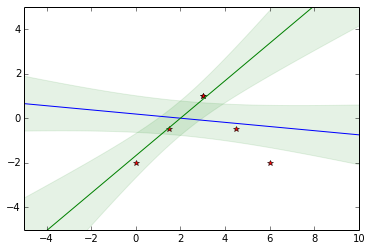

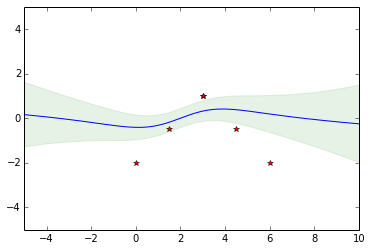

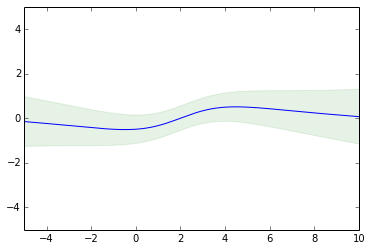

In [372]:
xa = np.linspace(0,3,3) 
ya = xa  - 2
xb = np.linspace(3,6,3) 
yb = 4 - xb

plt.plot(xa,ya,'r*')
plt.plot(xb,yb,'r*')

c = 2
s = 0.6
sig = 0.6

xt = np.linspace(0,6,6)

K = s*np.multiply.outer((xt - c), (xt - c)) + sig*np.eye(6,6)

xl = np.linspace(-6,12,300) 
k = s*np.multiply.outer((xt - c), (xl - c))

kss =  s*np.multiply.outer((xl - c), (xl - c)) + sig*np.eye(300,300)

Kinv = np.linalg.inv(K)
yt = np.concatenate([ya,yb])

m = np.dot(np.dot(k.T,Kinv), yt)
v = np.diag(kss - np.dot(np.dot(k.T,Kinv), k))

print np.dot(k.T,Kinv)

plt.plot(xl, m)
plt.fill_between(xl, (m + np.sqrt(v)).reshape(-1,), (m - np.sqrt(v)).reshape(-1,), alpha=0.1, color='green')


K = s*np.multiply.outer((xa - c), (xa - c)) + sig*np.eye(3,3)

k = s*np.multiply.outer((xa - c), (xl - c))

kss =  s*np.multiply.outer((xl - c), (xl - c)) + sig*np.eye(300,300)

Kinv = np.linalg.inv(K)
yt = np.concatenate([ya,yb])

ma = np.dot(np.dot(k.T,Kinv), ya)
va = np.diag(kss - np.dot(np.dot(k.T,Kinv), k))


plt.plot(xl, ma)
plt.fill_between(xl, (ma + np.sqrt(va)).reshape(-1,), (ma - np.sqrt(va)).reshape(-1,), alpha=0.1, color='green')
plt.ylim([-5,5])
plt.xlim([-5,10])
plt.figure()

bcm_v =  (1/v**2) + (1/va**2) #- (1/sig)
bcm_v = 1/bcm_v
bcm_m = bcm_v * ((ma/va**2) + (m/v**2))

plt.plot(xl, bcm_m)
plt.fill_between(xl, (bcm_m + np.sqrt(bcm_v)).reshape(-1,), (bcm_m - np.sqrt(bcm_v)).reshape(-1,), alpha=0.1, color='green')


plt.plot(xa,ya,'r*')
plt.plot(xb,yb,'r*')
plt.ylim([-5,5])
plt.xlim([-5,10])

d = np.mean(np.abs(np.subtract.outer(xa,xb)))
X = np.array([[0,d],[d,0]])
C2 = np.mean(s*np.multiply.outer((xa - c), (xt - c))) + sig #+ sig*np.eye(3,3)#np.exp(-0.5*X**2/len_scale)
C1 = np.mean(s*np.multiply.outer((xa - c), (xa - c))) + sig
C3 = np.mean(s*np.multiply.outer((xt - c), (xt - c))) + sig
C = np.array([[C1,C2],[C2,C3]])
cd = np.sqrt(1/np.diag(C))
C = np.multiply.outer(cd,cd)*C

k = []

for i in xrange(300):
    V = (np.array([v[i]**0.5, va[i]**0.5]))
    D = np.linalg.inv(C*np.multiply.outer(V,V) + np.eye(2)*1e-6)
    D_ = (np.sum(D,0)/(np.sum(D))).reshape(-1,1)
    #print D, D_, C*np.multiply.outer(V,V)
    k.append(D_)

k = np.array(k).reshape(300,-1)

er_m = ((k[:,0]*m + k[:,1]*ma))
er_v = (k[:,0]**2*v + k[:,1]**2*va)

print er_m.shape, er_v.shape, k.shape

plt.figure()
plt.plot(xl, er_m)
plt.fill_between(xl, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')
plt.ylim([-5,5])
plt.xlim([-5,10])

[ 0.08   0.317  0.322  0.43   0.496  0.815  0.843  0.981  0.991  1.334] [  3.216e-02   4.037e+00   3.975e+00   1.611e+00   1.688e+00   4.940e-01
   3.215e-01   1.829e-02   1.408e-02   3.670e-08]
Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	0.47 	0.15 	4.05 	0.00
B(P,Q) 		0.18 	0.03 	1.93 	0.00
W_0(P,Q) 	0.18 	0.00 	2.70 	0.00
W_2(P,Q) 	0.26 	0.10 	2.70 	0.00

Performance of BCM...
KL(P||Q) 	3.16 	1.47 	57.01 	0.00
B(P,Q) 		1.13 	0.29 	28.41 	0.00
W_0(P,Q) 	1.86 	0.12 	20.74 	0.00
W_2(P,Q) 	2.60 	1.04 	26.35 	0.00

Performance of ER...
KL(P||Q) 	0.02 	0.00 	11.02 	-0.00
B(P,Q) 		0.01 	0.00 	2.77 	0.00
W_0(P,Q) 	0.00 	0.00 	0.00 	0.00
W_2(P,Q) 	0.00 	0.00 	0.00 	-0.00



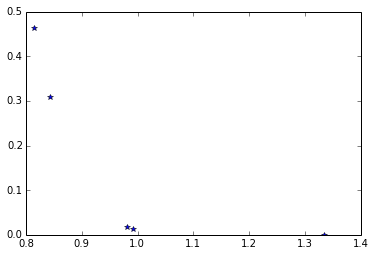

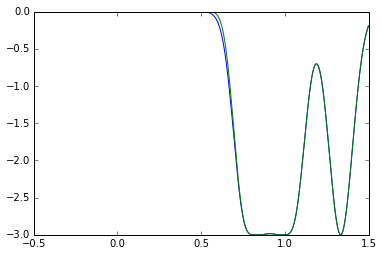

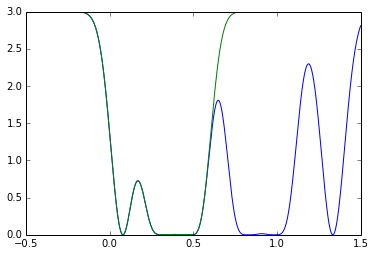

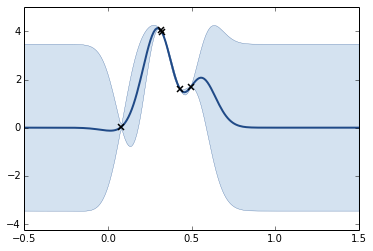

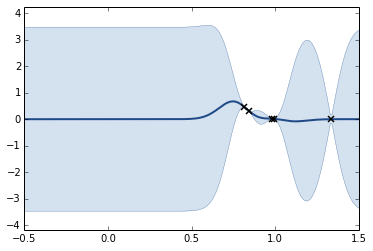

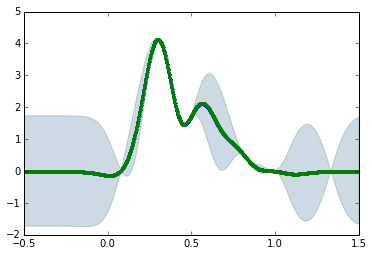

In [98]:
'''
Experimental Approach by finding correlations in expected error
'''

def er_GP(X,Y,z):
    # split the data into two parts
    d = X.shape[0]
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    print x, y
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    

    # There is no noise on our observations
    gp1['noise'] = 0
    
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    
    yy2 = (y2-gp1.predict(x2)[0])
    
    plt.figure()
    plt.plot(x2, yy2,'*')
    
    gp2 = GPy.models.GPRegression(x2,yy2,kern)
    gp2['noise'] = 0
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    plt.figure()
    plt.plot(z,((V2-3)))
    plt.plot(z,((V1*(V2-3)/3)))
    plt.figure()
    plt.plot(z,(V1*(1 + ((V2-3)/3))))
    plt.plot(z,V1)
    plt.figure()
    
    gp1.plot(plot_limits=[-0.5,1.5])
    gp2.plot(plot_limits=[-0.5,1.5])
    plt.figure()
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
        
    er_v =  V1*(1 + (V2-3)/3)
    er_m = M1 + M2
        
    return er_m, er_v

er_m, er_v = er_GP(x,y,z)

#gp_v[gp_v < 1e-10] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v, er_m, er_v)

print ''

[[ 3.     1.954]
 [ 1.954  3.   ]]
Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	0.15 	0.15 	0.23 	0.00
B(P,Q) 		0.03 	0.03 	0.05 	0.00
W_0(P,Q) 	0.03 	0.00 	0.36 	0.00
W_2(P,Q) 	0.26 	0.26 	0.46 	0.00

Performance of BCM...
KL(P||Q) 	0.00 	0.00 	0.00 	-0.00
B(P,Q) 		0.00 	0.00 	0.00 	0.00
W_0(P,Q) 	0.00 	0.00 	0.00 	0.00
W_2(P,Q) 	0.00 	0.00 	0.00 	-0.00

Performance of ER...


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:81: RuntimeWarning: invalid value encountered in sqrt
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:87: RuntimeWarning: invalid value encountered in sqrt


IndexError: too many indices for array

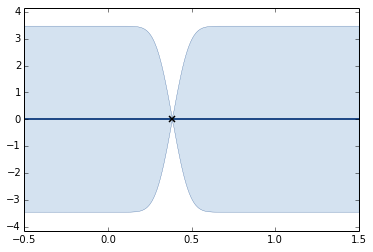

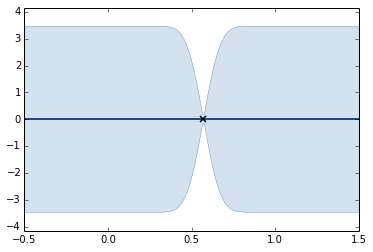

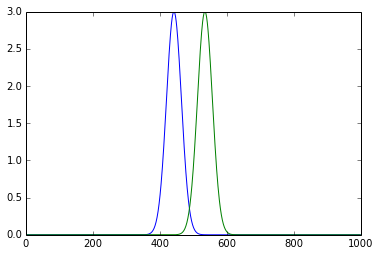

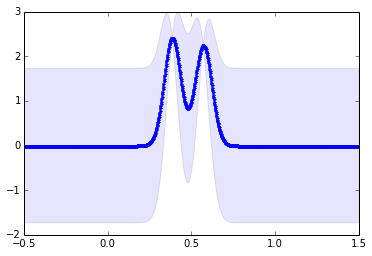

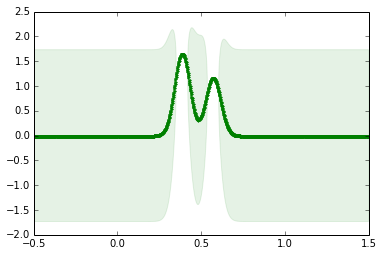

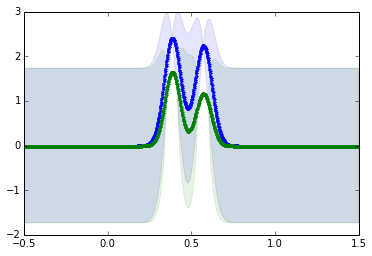

In [429]:
'''
Experimental Approach by finding correlations in expected error
'''

def er_GP(X,Y,z):
    # split the data into two parts
    d = X.shape[0]
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1 - y1.mean(),kern)
    gp2 = GPy.models.GPRegression(x2,y2 - y2.mean(),kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0

    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1]    
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
    
    xx = np.array([np.mean(x1), np.mean(x2)])
    d = 0.4
    K = np.mean(o_var*np.exp(-0.5*np.subtract.outer(x1,x2)**2/(len_scale*d)))
    K = np.array([[3., K],[K, 3.]])
    print K
    k = 3*(((3 - np.concatenate([V1,V2],1))/3)**(1/d))
    #print K, k[:,1:50:1000]
    M = np.concatenate([M1 + y1.mean(), M2 + y2.mean()],1)
    
    gp1.plot(plot_limits=[-0.5,1.5])
    gp2.plot(plot_limits=[-0.5,1.5])
    plt.figure()

    plt.plot(k)
    plt.figure()

    er_m = np.diag(np.dot(np.dot(k, np.linalg.inv(K)), M.T))
    er_v = (np.diag(3 - np.dot(np.dot(k, np.linalg.inv(K)), k.T))).reshape(er_m.shape)

        
    return er_m, er_v

er_m, er_v = er_GP(x,y,z)

gp_v[gp_v < 1e-10] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.figure()
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')


# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v, er_m, er_v)

print ''

(array([ 346.,   53.,   45.,   48.,   42.,   28.,   30.,   37.,   62.,  309.]),
 array([-0.037,  0.267,  0.57 ,  0.874,  1.178,  1.481,  1.785,  2.089,
         2.393,  2.696,  3.   ]),
 <a list of 10 Patch objects>)

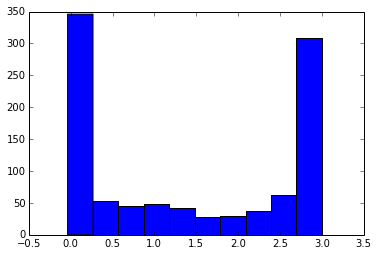

In [133]:
plt.hist(er_v)

In [180]:
a = np.array([[1,0.6],[0.6,0.8]])
print np.linalg.inv(a), 0.8/np.linalg.det(a)

aa = np.sum(a, 1)/np.sum(a)

print aa

[[ 1.818 -1.364]
 [-1.364  2.273]] 1.81818181818
[ 0.533  0.467] 0.765625


0.107610761607 -0.281676297372 [[ 1.    0.56]
 [ 0.56  1.  ]]
Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	2.56 	0.15 	213.92 	0.04
B(P,Q) 		0.08 	0.03 	1.19 	0.01
W_0(P,Q) 	0.04 	0.00 	0.57 	0.00
W_2(P,Q) 	0.25 	0.26 	0.67 	0.00

Performance of BCM...
KL(P||Q) 	2.44 	0.00 	213.93 	-0.00
B(P,Q) 		0.06 	0.00 	1.19 	0.00
W_0(P,Q) 	0.04 	0.00 	0.47 	0.00
W_2(P,Q) 	0.05 	0.00 	0.67 	-0.00

Performance of ER...
KL(P||Q) 	3.29 	0.00 	419.87 	-0.00
B(P,Q) 		0.07 	0.00 	1.35 	0.00
W_0(P,Q) 	0.05 	0.00 	0.61 	0.00
W_2(P,Q) 	0.07 	0.00 	0.83 	-0.00



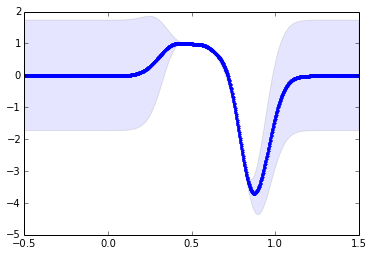

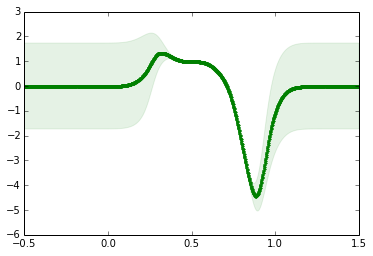

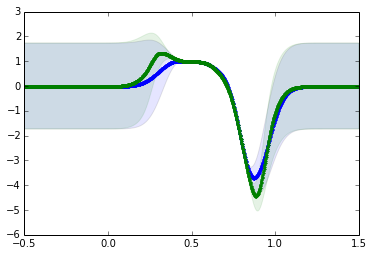

In [528]:
def true_GP(x,y,z):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp = GPy.models.GPRegression(x,y,kern)

    # There is no noise on our observations
    gp['noise'] = 0
    
    out = gp.predict(z)
    
    M = out[0]
    V = out[1]
        
    return M, V

def poe_GP(X,Y,z):
    # split the data into two parts
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    #x = X
    #y = Y
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1]    
    poe_v =  (1/V2) + (1/V1)
    poe_v = 1/poe_v
    poe_m = poe_v * ((M1/V1) + (M2/V2))
    
    return poe_m, poe_v

def bcm_GP(X,Y,z):
    # split the data into two parts
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    #x = X
    #y = Y
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    bcm_v =  (1/V2) + (1/V1) - (1/gp1.K[0,0])
    bcm_v = 1/bcm_v
    bcm_m = bcm_v * ((M1/V1) + (M2/V2))
    
    return bcm_m, bcm_v

'''
Experimental Approach 
'''

def er_GP(X,Y,z):
    # split the data into two parts
    d = X.shape[0]
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    #x = X
    #y = Y
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    n = z.shape[0]
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0

    #gp1.plot()
    #gp2.plot()
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1]    
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
        
    d = np.mean((np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,)))).min(0))/2 + np.mean((np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,)))).min(1))
    #print np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,))), np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,))).min(0), np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,))).min(1)
    #print x1,x2
    
    
    X = np.array([[0,d],[d,0]])
    C = (np.exp(-0.5*X**2/len_scale**2))
    Csum = 1 - np.sum(np.linalg.inv(C))
    print d, Csum, C
    
    #plt.figure()
    #plt.plot(np.exp(-0.5*(x1-z)**2/len_scale**2))
    #plt.plot(np.exp(-0.5*(x2-z)**2/len_scale**2))
        
    k = []
    
    
    for i in xrange(n):
        V = np.array([V1[i,0]**0.5, V2[i,0]**0.5])
        D = np.linalg.inv(C*np.multiply.outer(V,V) + np.eye(2)*1e-6)
        D_ = (np.sum(D,0)/(np.sum(D) + Csum/o_var)).reshape(-1,1)
        k.append(D_)
    
    k = np.array(k)
    
    v_ = (k[:,0].reshape(-1,1)*V1**-1 + k[:,1].reshape(-1,1)*V2**-1)**-1
    v = (k[:,0].reshape(-1,1)*V1**-1 + k[:,1].reshape(-1,1)*V2**-1 + (1 - k[:,0].reshape(-1,1) - k[:,1].reshape(-1,1))*o_var**-1)**-1
    er_m = ((k[:,0].reshape(-1,1)*M1 + k[:,1].reshape(-1,1)*M2))
    
    #plt.figure()
    #plt.plot(k[:,0])
    #plt.plot(k[:,1])
    #plt.figure()
    
    er_v = v#((k[:,0].reshape(-1,1)*np.sqrt(V1) + k[:,1].reshape(-1,1)*np.sqrt(V1))**2)#/(k[:,0]**2 + k[:,1]**2)

        
    return er_m, er_v

er_m, er_v = er_GP(x,y,z)

er_v[er_v < 1e-10] = 1e-10

# Plot GPs
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.figure()
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')


# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v,poe_m, poe_v)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v, bcm_m, bcm_v)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v, er_m, er_v)

print ''

0.333447654104 -0.992327122244 [[ 1.     0.004]
 [ 0.004  1.   ]]
Performance of PoE...
		 Mean 	Median	 Max 	 Min
KL(P||Q) 	1.69 	0.08 	24.50 	0.00
B(P,Q) 		0.41 	0.02 	5.57 	0.00
W_0(P,Q) 	2.92 	0.00 	48.48 	0.00
W_2(P,Q) 	2.95 	0.04 	48.49 	0.00

Performance of BCM...
KL(P||Q) 	0.16 	0.00 	1.26 	0.00
B(P,Q) 		0.06 	0.00 	0.54 	0.00
W_0(P,Q) 	0.15 	0.00 	2.51 	0.00
W_2(P,Q) 	0.15 	0.00 	2.53 	-0.00

Performance of ER...
KL(P||Q) 	0.19 	0.01 	1.28 	0.00
B(P,Q) 		0.06 	0.00 	0.55 	0.00
W_0(P,Q) 	0.15 	0.00 	2.52 	0.00
W_2(P,Q) 	0.15 	0.00 	2.54 	0.00



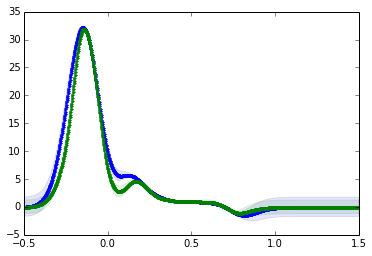

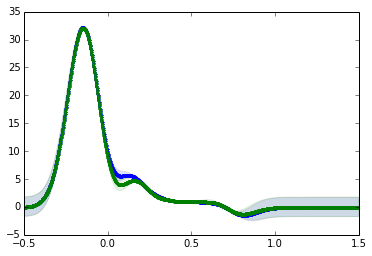

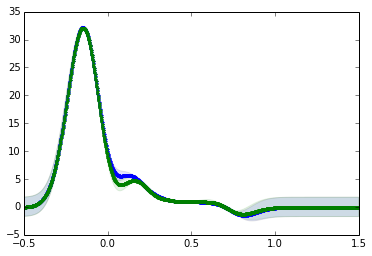

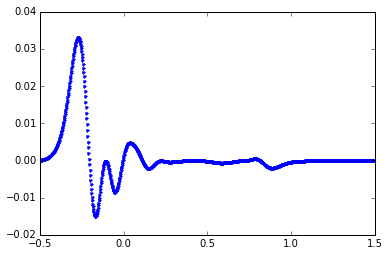

In [534]:
'''def func(x):
    # Lets play around with a gausian mixture
    # and pretend we dont know what it is
    var_1 = 0.01
    var_2 = 0.03
    
    mean_1 = 0.3
    mean_2 = 0.6
    
    return ((1/np.sqrt(2*np.pi*var_1))*np.exp(-pow(x-mean_1,2)/var_1)) \
                + ((1/np.sqrt(2*np.pi*var_2))*np.exp(-pow(x-mean_2,2)/var_2))'''

def func(x):
    # Lets play around with a gausian mixture
    # and pretend we dont know what it is
    return 1 - ((x-0.5)*5)**3

x = np.random.randn(6)/3 + 0.5
x = np.concatenate([x,x+0.001])
z = np.linspace(-0.5,1.5,1000)
y = func(x)

gp_m, gp_v = true_GP(x,y,z)
poe_m, poe_v = poe_GP(x,y,z)
bcm_m, bcm_v = bcm_GP(x,y,z)

gp_v[gp_v < 1e-5] = 1e-5
poe_v[poe_v < 1e-5] = 1e-5
bcm_v[bcm_v < 1e-5] = 1e-5

er_m, er_v = er_GP(x,y,z)

er_v[er_v < 1e-10] = 1e-10

# Plot GPs
plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, poe_m, 'g.')
plt.fill_between(z, (poe_m + np.sqrt(poe_v)).reshape(-1,), (poe_m - np.sqrt(poe_v)).reshape(-1,), alpha=0.1, color='green')

plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, bcm_m, 'g.')
plt.fill_between(z, (bcm_m + np.sqrt(bcm_v)).reshape(-1,), (bcm_m - np.sqrt(bcm_v)).reshape(-1,), alpha=0.1, color='green')

plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')

plt.figure()
plt.plot(z, bcm_m - er_m, 'b.')

# Print Performances
print 'Performance of PoE...'
print '\t\t Mean \tMedian\t Max \t Min'
performance(gp_m, gp_v**0.5,poe_m, poe_v**0.5)

print ''

print 'Performance of BCM...'
performance(gp_m, gp_v**0.5, bcm_m, bcm_v**0.5)

print ''

print 'Performance of ER...'
performance(gp_m, gp_v**0.5, er_m, er_v**0.5)

print ''

0.0211811853235 -0.00112160605892 [[ 1.     0.998]
 [ 0.998  1.   ]]


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:261: RuntimeWarning: invalid value encountered in sqrt


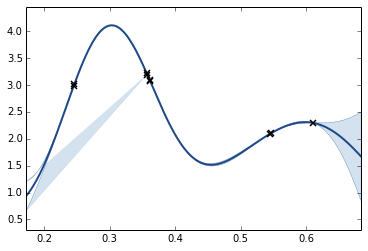

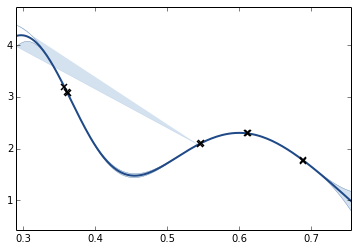

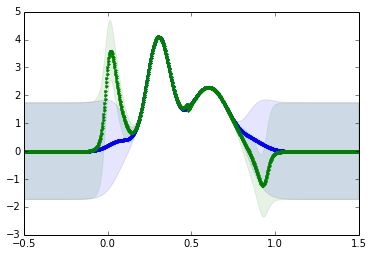

In [557]:
# We will examine a simple 1D example

def func(x):
    # Lets play around with a gausian mixture
    # and pretend we dont know what it is
    var_1 = 0.01
    var_2 = 0.03
    
    mean_1 = 0.3
    mean_2 = 0.6
    
    return ((1/np.sqrt(2*np.pi*var_1))*np.exp(-pow(x-mean_1,2)/var_1)) \
                + ((1/np.sqrt(2*np.pi*var_2))*np.exp(-pow(x-mean_2,2)/var_2))

def true_GP(x,y,z):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    kern_lin =  GPy.kern.linear(input_dim=1)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise 

    # Make the Gaussian Process using the GPy interface
    gp = GPy.models.GPRegression(x,y,kern)

    # There is no noise on our observations
    gp['noise'] = 0
    
    #gp.optimize()
    
    out = gp.predict(z)
    
    M = out[0]
    V = out[1]
        
    return M, V

def poe_GP(X,Y,z):
    # split the data into two parts
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    #x = X
    #y = Y
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1]    
    poe_v =  (1/V2) + (1/V1)
    poe_v = 1/poe_v
    poe_m = poe_v * ((M1/V1) + (M2/V2))
    
    return poe_m, poe_v

def bcm_GP(X,Y,z):
    # split the data into two parts
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    #x = X
    #y = Y
    d = x.shape[0]
    x1 = x[:np.floor(d/2)].reshape(-1,1)
    x2 = x[np.floor(d/2):].reshape(-1,1)
    y1 = y[:np.floor(d/2)].reshape(-1,1)
    y2 = y[np.floor(d/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1] 
    
    bcm_v =  (1/V2) + (1/V1) - (1/gp1.K[0,0])
    bcm_v = 1/bcm_v
    bcm_m = bcm_v * ((M1/V1) + (M2/V2))
    
    return bcm_m, bcm_v

'''
Experimental Approach 
'''

def er_GP(X,Y,z):
    # split the data into two parts
    d = X.shape[0]
    y = np.array([yy for (xx,yy) in sorted(zip(X,Y))])
    x = np.array([xx for (xx,yy) in sorted(zip(X,Y))])
    #x = X
    #y = Y
    x1 = x[:np.floor(d*1.5/2)].reshape(-1,1)
    x2 = x[np.floor(d*0.5/2):].reshape(-1,1)
    y1 = y[:np.floor(d*1.5/2)].reshape(-1,1)
    y2 = y[np.floor(d*0.5/2):].reshape(-1,1)
    z = z.reshape(-1,1)
    n = z.shape[0]
    
    # length scale and output variance
    noise = 0.0
    len_scale = 0.1
    o_var = 3.0

    # RBF (or Sqared Exp.) Kernel
    kern_rbf =  GPy.kern.rbf(input_dim=1, variance=o_var, lengthscale=len_scale)

    # Add noise if nessesary (white noise)
    kern_noise =  GPy.kern.white(input_dim=1, variance=noise)

    # Combine the kernels for the GP
    kern = kern_rbf + kern_noise

    # Make the Gaussian Process using the GPy interface
    gp1 = GPy.models.GPRegression(x1,y1,kern)
    gp2 = GPy.models.GPRegression(x2,y2,kern)

    # There is no noise on our observations
    gp1['noise'] = 0
    gp2['noise'] = 0
    
    #gp1.optimize()
    #gp2.optimize()

    #gp1.plot()
    #gp2.plot()
    
    # Merge Predictions
    out = gp1.predict(z)
    M1 = out[0]
    V1 = out[1]
    out = gp2.predict(z)
    M2 = out[0]
    V2 = out[1]  
    
    gp1.plot()
    gp2.plot()
    
    V1[V1 < 1e-6] = 1e-6
    V2[V2 < 1e-6] = 1e-6
        
    d = np.mean((np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,)))).min(0))/2 + np.mean((np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,)))).min(1))/2
    #print np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,))), np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,))).min(0), np.abs(np.subtract.outer(x1.reshape(-1,),x2.reshape(-1,))).min(1)
    #print x1,x2
    
    
    X = np.array([[0,d],[d,0]])
    C = (np.exp(-0.5*X**2/len_scale))
    Csum = 1 - np.sum(np.linalg.inv(C))
    print d, Csum, C
    
    #plt.figure()
    #plt.plot(np.exp(-0.5*(x1-z)**2/len_scale**2))
    #plt.plot(np.exp(-0.5*(x2-z)**2/len_scale**2))
        
    k = []
    
    
    for i in xrange(n):
        V = np.array([V1[i,0]**0.5, V2[i,0]**0.5])
        D = np.linalg.inv(C*np.multiply.outer(V,V) + np.eye(2)*1e-6)
        D_ = (np.sum(D,0)/(np.sum(D) + Csum/o_var)).reshape(-1,1)
        k.append(D_)
    
    k = np.array(k)
    
    v_ = (k[:,0].reshape(-1,1)*V1**-1 + k[:,1].reshape(-1,1)*V2**-1)**-1
    v = (k[:,0].reshape(-1,1)*V1**-1 + k[:,1].reshape(-1,1)*V2**-1 + (1 - k[:,0].reshape(-1,1) - k[:,1].reshape(-1,1))*o_var**-1)**-1
    er_m = ((k[:,0].reshape(-1,1)*M1 + k[:,1].reshape(-1,1)*M2))
    
    #plt.figure()
    #plt.plot(k[:,0])
    #plt.plot(k[:,1])
    #plt.figure()
    
    er_v = v#((k[:,0].reshape(-1,1)*np.sqrt(V1) + k[:,1].reshape(-1,1)*np.sqrt(V1))**2)#/(k[:,0]**2 + k[:,1]**2)

        
    return er_m, er_v

x = np.random.randn(6)/3 + 0.5
x = np.concatenate([x,x+0.001])
z = np.linspace(-0.5,1.5,1000)
y = func(x)

gp_m, gp_v = true_GP(x,y,z)


er_m, er_v = er_GP(x,y,z)

er_v[er_v < 1e-10] = 1e-10

# Plot GPs
plt.figure()
plt.plot(z, gp_m, '.')
plt.fill_between(z, (gp_m + np.sqrt(gp_v)).reshape(-1,), (gp_m - np.sqrt(gp_v)).reshape(-1,), alpha=0.1)
plt.plot(z, er_m, 'g.')
plt.fill_between(z, (er_m + np.sqrt(er_v)).reshape(-1,), (er_m - np.sqrt(er_v)).reshape(-1,), alpha=0.1, color='green')
